In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
Dataset_dir = ["./train.csv", "./store.csv","./test.csv"]
pd.options.display.max_columns = None

In [3]:
def load_data(dir):
    data = pd.read_csv(dir[0],parse_dates=[2])
    store = pd.read_csv(dir[1])
    test = pd.read_csv(dir[2],parse_dates=[3])
    return data,store,test

In [4]:
train,store,test = load_data(Dataset_dir)
train = train[train['Open'] != 0]
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')
print(train.columns)
print(test.columns)

D:\AnaconDA\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')
Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
#对时间序列进行分析
#总的销售趋势2013-2015年
# train['date'] = pd.to_datetime(train.Date)
# data = train.loc[:,['Sales']]
# data = data.set_index(train.date)
# data.plot()

# weekly = data.resample('W').sum()
# weekly.plot()

# dayily = data.resample('D').sum()
# dayily.plot()

In [6]:
TESTID = test['Id']

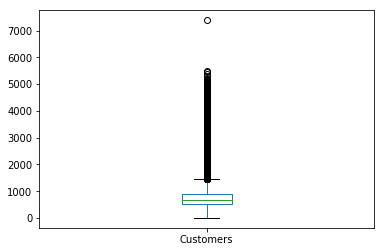

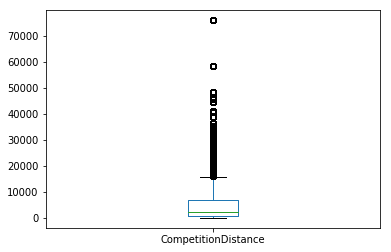

In [7]:
train.Customers.plot(kind='box')
plt.show()
train.CompetitionDistance.plot(kind='box')
plt.show()

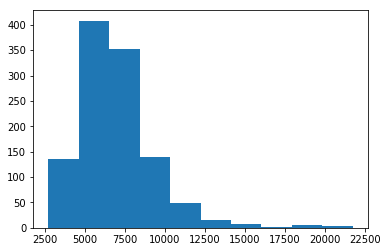

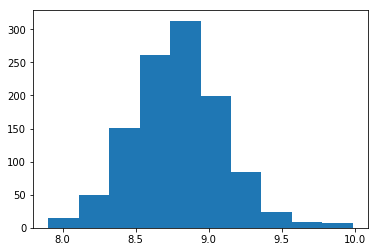

In [8]:
sales_mean = train.groupby('Store')['Sales'].mean()
plt.hist(sales_mean)
plt.show()
plt.hist(np.log1p(sales_mean))
plt.show()

In [9]:
Store_DaysWeek = train.groupby(['Store','DayOfWeek'])
sw_mean = Store_DaysWeek["Sales"].mean()

In [10]:
def build_feature(data,istrain):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #CART回归树不需要预处理数据和NAn值
#     distance_max = max(data.CompetitionDistance)
#     data.CompetitionDistance.mask(data.CompetitionDistance.isna(),other=distance_max,inplace=True)
#     print(data.CompetitionDistance.isnull().any())
#     min_max_scaler = MinMaxScaler()
#     scaledata = min_max_scaler.fit_transform(data[['CompetitionDistance']])
#     data.drop("CompetitionDistance",axis=1)
#     data['CompetitionDistance'] = scaledata
    #时间序列问题 需要考虑进时间的因素
    data['Year'] = data.Date.dt.year
    print(data['Year'].dtype)
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    
    if istrain:
        data.drop(['Store','Open','Date','Customers','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Store','Open','Date','Customers','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    else:
        data.drop(['Id','Store','Open','Date','PromoInterval',],axis=1,inplace=True)
        #data.drop(['Id','Store','Open','Date','PromoInterval','SchoolHoliday','Promo2','StateHoliday','Promo2SinceWeek'],axis=1,inplace=True)
    print(data.columns)

In [11]:
#build train data
build_feature(train,True)
#build test data
build_feature(test,False)

int64
Index(['DayOfWeek', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')
int64
Index(['DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'Year', 'Month', 'Day'],
      dtype='object')


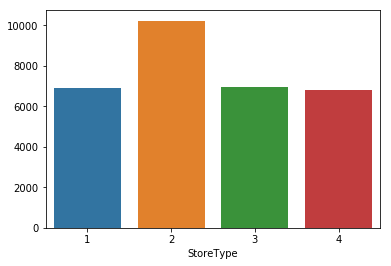

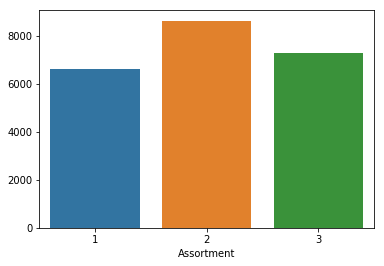

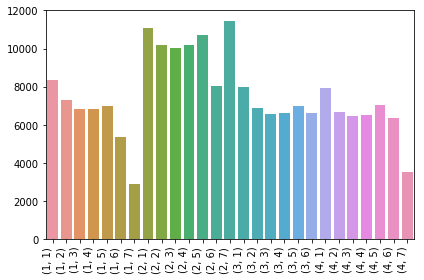

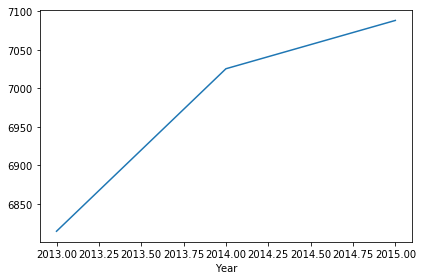

In [12]:
ST_gp = train.groupby('StoreType')['Sales'].agg('mean')
import seaborn as sns
sns.barplot(ST_gp.index,ST_gp.values)
plt.show()

As_gp = train.groupby('Assortment')['Sales'].agg('mean')
sns.barplot(As_gp.index,As_gp.values)
plt.show()
Dayweek_gp = train.groupby(['StoreType','DayOfWeek'])['Sales'].agg('mean')
ax = sns.barplot(Dayweek_gp.index,Dayweek_gp.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
plt.tight_layout()
plt.show()

#每年销售额的趋势
YearS_gp = train.groupby(['Year'])['Sales'].agg("mean")
ax2 = sns.lineplot(YearS_gp.index,YearS_gp.values)
plt.tight_layout()
plt.show()

In [13]:
#split train vaild data
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
print(X_train.shape)
print(X_valid.shape)
Y_train = X_train["Sales"]
Y_valid = X_valid["Sales"]
X_train.drop("Sales",axis=1,inplace=True)
X_valid.drop("Sales",axis=1,inplace=True)

(834259, 16)
(10133, 16)


D:\AnaconDA\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


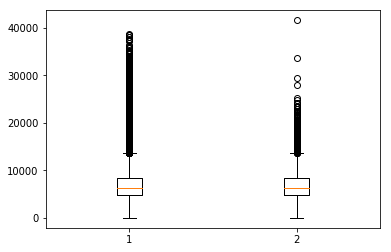

In [14]:
plt.boxplot([Y_train,Y_valid])
plt.show()

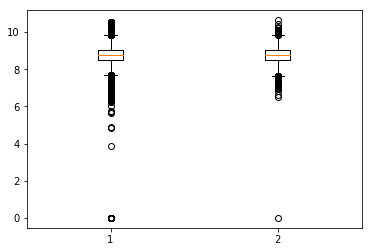

In [15]:
Y_train = np.log1p(Y_train)
Y_valid = np.log1p(Y_valid)
plt.boxplot([Y_train,Y_valid])
plt.show()

In [16]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [17]:
params = {"objective": "reg:linear",
          "eta": 0.1,
          "max_depth": 12,
          "min_child_weight":1,
          "gamma" :0,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }
num_trees = 1000

# dtrain = xgb.DMatrix(X_train, Y_train)
# dvalid = xgb.DMatrix(X_valid, Y_valid)
# dtest = xgb.DMatrix(test)
eval_set= [(X_train, Y_train),(X_valid, Y_valid)]
#watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
ret = {}
import time
start = time.time()
estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=num_trees,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1)
estimator.fit(X_train, Y_train,eval_metric=rmspe_xg, eval_set=eval_set, verbose=True,early_stopping_rounds=20)
#gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()
print("Train use time:",end-start)

D:\AnaconDA\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	validation_0-rmse:7.44317	validation_1-rmse:7.43873	validation_0-rmspe:0.999496	validation_1-rmspe:0.999477
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 20 rounds.
[1]	validation_0-rmse:6.70068	validation_1-rmse:6.69677	validation_0-rmspe:0.998793	validation_1-rmspe:0.998771
[2]	validation_0-rmse:6.03251	validation_1-rmse:6.02901	validation_0-rmspe:0.997524	validation_1-rmspe:0.997498
[3]	validation_0-rmse:5.43118	validation_1-rmse:5.42795	validation_0-rmspe:0.99539	validation_1-rmspe:0.99536
[4]	validation_0-rmse:4.89003	validation_1-rmse:4.88712	validation_0-rmspe:0.99202	validation_1-rmspe:0.991984
[5]	validation_0-rmse:4.40306	validation_1-rmse:4.40039	validation_0-rmspe:0.986986	validation_1-rmspe:0.986942
[6]	validation_0-rmse:3.96507	validation_1-rmse:3.96277	validation_0-rmspe:0.979815	validation_1-rmspe:0.979764
[7]	validation_0-rmse:3.57084	validation_1-rmse:3.56869	va

[71]	validation_0-rmse:0.160647	validation_1-rmse:0.174181	validation_0-rmspe:0.196863	validation_1-rmspe:0.161892
[72]	validation_0-rmse:0.160275	validation_1-rmse:0.17384	validation_0-rmspe:0.196565	validation_1-rmspe:0.161605
[73]	validation_0-rmse:0.159788	validation_1-rmse:0.173575	validation_0-rmspe:0.196263	validation_1-rmspe:0.161416
[74]	validation_0-rmse:0.159538	validation_1-rmse:0.173343	validation_0-rmspe:0.196107	validation_1-rmspe:0.161217
[75]	validation_0-rmse:0.158533	validation_1-rmse:0.172468	validation_0-rmspe:0.19533	validation_1-rmspe:0.160309
[76]	validation_0-rmse:0.15641	validation_1-rmse:0.170589	validation_0-rmspe:0.193435	validation_1-rmspe:0.158296
[77]	validation_0-rmse:0.155816	validation_1-rmse:0.170088	validation_0-rmspe:0.192655	validation_1-rmspe:0.157722
[78]	validation_0-rmse:0.155612	validation_1-rmse:0.169916	validation_0-rmspe:0.192748	validation_1-rmspe:0.157572
[79]	validation_0-rmse:0.155105	validation_1-rmse:0.169386	validation_0-rmspe:0.192

[143]	validation_0-rmse:0.117504	validation_1-rmse:0.142439	validation_0-rmspe:0.135417	validation_1-rmspe:0.124681
[144]	validation_0-rmse:0.117193	validation_1-rmse:0.142316	validation_0-rmspe:0.135157	validation_1-rmspe:0.124529
[145]	validation_0-rmse:0.116586	validation_1-rmse:0.141903	validation_0-rmspe:0.134657	validation_1-rmspe:0.12406
[146]	validation_0-rmse:0.116281	validation_1-rmse:0.141728	validation_0-rmspe:0.134429	validation_1-rmspe:0.123815
[147]	validation_0-rmse:0.115944	validation_1-rmse:0.14148	validation_0-rmspe:0.134101	validation_1-rmspe:0.12351
[148]	validation_0-rmse:0.115712	validation_1-rmse:0.141379	validation_0-rmspe:0.133915	validation_1-rmspe:0.123401
[149]	validation_0-rmse:0.115453	validation_1-rmse:0.141215	validation_0-rmspe:0.133646	validation_1-rmspe:0.123187
[150]	validation_0-rmse:0.115134	validation_1-rmse:0.140984	validation_0-rmspe:0.133444	validation_1-rmspe:0.122985
[151]	validation_0-rmse:0.11494	validation_1-rmse:0.14089	validation_0-rmsp

[214]	validation_0-rmse:0.101289	validation_1-rmse:0.134425	validation_0-rmspe:0.112569	validation_1-rmspe:0.115824
[215]	validation_0-rmse:0.101038	validation_1-rmse:0.134363	validation_0-rmspe:0.112423	validation_1-rmspe:0.115742
[216]	validation_0-rmse:0.100863	validation_1-rmse:0.134284	validation_0-rmspe:0.112239	validation_1-rmspe:0.115466
[217]	validation_0-rmse:0.100568	validation_1-rmse:0.134246	validation_0-rmspe:0.11205	validation_1-rmspe:0.11541
[218]	validation_0-rmse:0.100394	validation_1-rmse:0.134163	validation_0-rmspe:0.111899	validation_1-rmspe:0.115276
[219]	validation_0-rmse:0.100281	validation_1-rmse:0.134117	validation_0-rmspe:0.111798	validation_1-rmspe:0.11523
[220]	validation_0-rmse:0.100243	validation_1-rmse:0.1341	validation_0-rmspe:0.111769	validation_1-rmspe:0.115245
[221]	validation_0-rmse:0.100125	validation_1-rmse:0.134041	validation_0-rmspe:0.111647	validation_1-rmspe:0.115168
[222]	validation_0-rmse:0.099928	validation_1-rmse:0.133949	validation_0-rmsp

[285]	validation_0-rmse:0.090888	validation_1-rmse:0.131521	validation_0-rmspe:0.096991	validation_1-rmspe:0.111398
[286]	validation_0-rmse:0.09065	validation_1-rmse:0.131477	validation_0-rmspe:0.096619	validation_1-rmspe:0.111328
[287]	validation_0-rmse:0.090534	validation_1-rmse:0.13145	validation_0-rmspe:0.096523	validation_1-rmspe:0.111292
[288]	validation_0-rmse:0.090327	validation_1-rmse:0.131426	validation_0-rmspe:0.096372	validation_1-rmspe:0.111244
[289]	validation_0-rmse:0.090257	validation_1-rmse:0.131381	validation_0-rmspe:0.096313	validation_1-rmspe:0.111191
[290]	validation_0-rmse:0.090036	validation_1-rmse:0.131298	validation_0-rmspe:0.095084	validation_1-rmspe:0.110922
[291]	validation_0-rmse:0.089894	validation_1-rmse:0.131251	validation_0-rmspe:0.09498	validation_1-rmspe:0.110869
[292]	validation_0-rmse:0.089753	validation_1-rmse:0.131217	validation_0-rmspe:0.094893	validation_1-rmspe:0.110858
[293]	validation_0-rmse:0.089677	validation_1-rmse:0.131157	validation_0-rm

[356]	validation_0-rmse:0.083428	validation_1-rmse:0.130114	validation_0-rmspe:0.085687	validation_1-rmspe:0.108887
[357]	validation_0-rmse:0.083362	validation_1-rmse:0.130104	validation_0-rmspe:0.085588	validation_1-rmspe:0.108877
[358]	validation_0-rmse:0.083294	validation_1-rmse:0.130132	validation_0-rmspe:0.085524	validation_1-rmspe:0.108922
[359]	validation_0-rmse:0.083227	validation_1-rmse:0.130104	validation_0-rmspe:0.085394	validation_1-rmspe:0.108902
[360]	validation_0-rmse:0.083165	validation_1-rmse:0.130103	validation_0-rmspe:0.08533	validation_1-rmspe:0.108889
[361]	validation_0-rmse:0.083074	validation_1-rmse:0.130119	validation_0-rmspe:0.08526	validation_1-rmspe:0.10883
[362]	validation_0-rmse:0.082994	validation_1-rmse:0.130114	validation_0-rmspe:0.085091	validation_1-rmspe:0.108821
[363]	validation_0-rmse:0.082839	validation_1-rmse:0.130134	validation_0-rmspe:0.085002	validation_1-rmspe:0.108855
[364]	validation_0-rmse:0.082728	validation_1-rmse:0.130103	validation_0-rm

[427]	validation_0-rmse:0.077641	validation_1-rmse:0.129618	validation_0-rmspe:0.079764	validation_1-rmspe:0.107627
[428]	validation_0-rmse:0.077587	validation_1-rmse:0.129628	validation_0-rmspe:0.079722	validation_1-rmspe:0.107655
[429]	validation_0-rmse:0.077546	validation_1-rmse:0.129598	validation_0-rmspe:0.079702	validation_1-rmspe:0.107669
[430]	validation_0-rmse:0.077483	validation_1-rmse:0.129589	validation_0-rmspe:0.079629	validation_1-rmspe:0.107661
[431]	validation_0-rmse:0.077438	validation_1-rmse:0.129593	validation_0-rmspe:0.079559	validation_1-rmspe:0.107571
[432]	validation_0-rmse:0.077372	validation_1-rmse:0.129576	validation_0-rmspe:0.079482	validation_1-rmspe:0.107576
[433]	validation_0-rmse:0.077328	validation_1-rmse:0.129561	validation_0-rmspe:0.079435	validation_1-rmspe:0.107564
[434]	validation_0-rmse:0.077251	validation_1-rmse:0.129525	validation_0-rmspe:0.079396	validation_1-rmspe:0.107486
[435]	validation_0-rmse:0.077218	validation_1-rmse:0.129527	validation_0

[498]	validation_0-rmse:0.073234	validation_1-rmse:0.129268	validation_0-rmspe:0.074881	validation_1-rmspe:0.106554
[499]	validation_0-rmse:0.073165	validation_1-rmse:0.129251	validation_0-rmspe:0.074831	validation_1-rmspe:0.106545
[500]	validation_0-rmse:0.073116	validation_1-rmse:0.129235	validation_0-rmspe:0.074788	validation_1-rmspe:0.106517
[501]	validation_0-rmse:0.073064	validation_1-rmse:0.129227	validation_0-rmspe:0.074757	validation_1-rmspe:0.106489
[502]	validation_0-rmse:0.073033	validation_1-rmse:0.129249	validation_0-rmspe:0.07457	validation_1-rmspe:0.106535
[503]	validation_0-rmse:0.072979	validation_1-rmse:0.129247	validation_0-rmspe:0.074501	validation_1-rmspe:0.106505
[504]	validation_0-rmse:0.07294	validation_1-rmse:0.129248	validation_0-rmspe:0.074448	validation_1-rmspe:0.106505
[505]	validation_0-rmse:0.072907	validation_1-rmse:0.129262	validation_0-rmspe:0.074414	validation_1-rmspe:0.10651
[506]	validation_0-rmse:0.072839	validation_1-rmse:0.129261	validation_0-rm

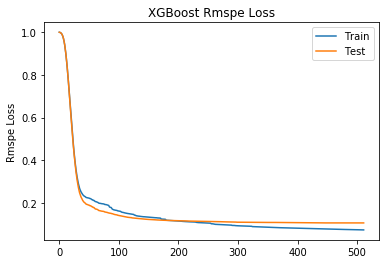

In [18]:
from matplotlib import pyplot
results = estimator.evals_result()
epochs = len(results['validation_0']['rmspe'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmspe'], label='Train')
ax.plot(x_axis, results['validation_1']['rmspe'], label='Test')
ax.legend()
pyplot.ylabel('Rmspe Loss')
pyplot.title('XGBoost Rmspe Loss')
pyplot.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

def customer_rmspe_xg(yhat, y):
    # y = y.values
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe

param_test1 = {
 'max_depth':range(10,13,1),
 'subsample': [0.6,0.7,0.8,0.9],
 'learning_rate': [0.08,0.1,0.11,0.12,0.13]
}
nums_round = 492
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=12,learning_rate =0.1,n_jobs =4, n_estimators=nums_round,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test1,cv=3,verbose=2,scoring=make_scorer(customer_rmspe_xg,greater_is_better=False))
gsearch1.fit(X_train, Y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] learning_rate=0.08, max_depth=10, subsample=0.6 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. learning_rate=0.08, max_depth=10, subsample=0.6, total= 5.8min
[CV] learning_rate=0.08, max_depth=10, subsample=0.6 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min remaining:    0.0s


[CV] .. learning_rate=0.08, max_depth=10, subsample=0.6, total= 5.8min
[CV] learning_rate=0.08, max_depth=10, subsample=0.6 .................
[CV] .. learning_rate=0.08, max_depth=10, subsample=0.6, total= 5.5min
[CV] learning_rate=0.08, max_depth=10, subsample=0.7 .................
[CV] .. learning_rate=0.08, max_depth=10, subsample=0.7, total= 5.9min
[CV] learning_rate=0.08, max_depth=10, subsample=0.7 .................
[CV] .. learning_rate=0.08, max_depth=10, subsample=0.7, total= 5.8min
[CV] learning_rate=0.08, max_depth=10, subsample=0.7 .................
[CV] .. learning_rate=0.08, max_depth=10, subsample=0.7, total= 5.8min
[CV] learning_rate=0.08, max_depth=10, subsample=0.8 .................
[CV] .. learning_rate=0.08, max_depth=10, subsample=0.8, total= 5.4min
[CV] learning_rate=0.08, max_depth=10, subsample=0.8 .................
[CV] .. learning_rate=0.08, max_depth=10, subsample=0.8, total= 5.1min
[CV] learning_rate=0.08, max_depth=10, subsample=0.8 .................
[CV] .

In [26]:
print(gsearch1.best_params_)
print(gsearch1.best_score_)

{'max_depth': 10}
-0.20115284889529902


param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(max_depth=9,learning_rate =0.1, n_estimators=36,min_child_weight=3, gamma=0,verbose = 10,subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1),
                        param_grid = param_test2,scoring ='neg_mean_squared_error',cv=5)

gsearch2.fit(X_train, Y_train)


In [27]:
print(gsearch2.best_params_)

{'gamma': 0.1}


In [73]:
params2 = {"objective": "reg:linear",
          "eta": 0.2,
          "max_depth": 12,
          "min_child_weight":4,
          "gamma" :0.1,
          "subsample": 0.7,
          "colsample_bytree": 0.7,
          "silent": 1
          }

start = time.time()
gbm2 = xgb.train(params2, dtrain, 300, evals=watchlist, early_stopping_rounds=50,evals_result =ret, feval=rmspe_xg, verbose_eval=True)
end = time.time()

[0]	eval-rmse:6.61459	train-rmse:6.61894	eval-rmspe:0.998646	train-rmspe:0.998669
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:5.29584	train-rmse:5.29992	eval-rmspe:0.994636	train-rmspe:0.994675
[2]	eval-rmse:4.24143	train-rmse:4.24475	eval-rmspe:0.984512	train-rmspe:0.984574
[3]	eval-rmse:3.39884	train-rmse:3.40132	eval-rmspe:0.96411	train-rmspe:0.964207
[4]	eval-rmse:2.72533	train-rmse:2.72748	eval-rmspe:0.929864	train-rmspe:0.930031
[5]	eval-rmse:2.18715	train-rmse:2.18856	eval-rmspe:0.880713	train-rmspe:0.880935
[6]	eval-rmse:1.75839	train-rmse:1.75941	eval-rmspe:0.817425	train-rmspe:0.817879
[7]	eval-rmse:1.41743	train-rmse:1.41803	eval-rmspe:0.743716	train-rmspe:0.744687
[8]	eval-rmse:1.1459	train-rmse:1.1466	eval-rmspe:0.664653	train-rmspe:0.666665
[9]	eval-rmse:0.931714	train-rmse:0.932273	eval-rmspe:0.585377	train-rmspe:0.589114
[10]	eval-rmse:0.756586	train-rmse

[96]	eval-rmse:0.138973	train-rmse:0.119073	eval-rmspe:0.120678	train-rmspe:0.163384
[97]	eval-rmse:0.13894	train-rmse:0.118893	eval-rmspe:0.120613	train-rmspe:0.163226
[98]	eval-rmse:0.138951	train-rmse:0.118786	eval-rmspe:0.120606	train-rmspe:0.163189
[99]	eval-rmse:0.138824	train-rmse:0.118624	eval-rmspe:0.120402	train-rmspe:0.163015
[100]	eval-rmse:0.138793	train-rmse:0.118578	eval-rmspe:0.120377	train-rmspe:0.163249
[101]	eval-rmse:0.138611	train-rmse:0.118318	eval-rmspe:0.120166	train-rmspe:0.162939
[102]	eval-rmse:0.138572	train-rmse:0.118088	eval-rmspe:0.120133	train-rmspe:0.162868
[103]	eval-rmse:0.138488	train-rmse:0.117889	eval-rmspe:0.120042	train-rmspe:0.162703
[104]	eval-rmse:0.138099	train-rmse:0.117389	eval-rmspe:0.11954	train-rmspe:0.162056
[105]	eval-rmse:0.137963	train-rmse:0.11713	eval-rmspe:0.119516	train-rmspe:0.161778
[106]	eval-rmse:0.137835	train-rmse:0.116971	eval-rmspe:0.119292	train-rmspe:0.159993
[107]	eval-rmse:0.137734	train-rmse:0.11683	eval-rmspe:0.1192

[192]	eval-rmse:0.135173	train-rmse:0.106415	eval-rmspe:0.115288	train-rmspe:0.139224
[193]	eval-rmse:0.135154	train-rmse:0.106376	eval-rmspe:0.115269	train-rmspe:0.13919
[194]	eval-rmse:0.135199	train-rmse:0.106334	eval-rmspe:0.11531	train-rmspe:0.139096
[195]	eval-rmse:0.13519	train-rmse:0.106204	eval-rmspe:0.115289	train-rmspe:0.138995
[196]	eval-rmse:0.13518	train-rmse:0.106161	eval-rmspe:0.11532	train-rmspe:0.138973
[197]	eval-rmse:0.135215	train-rmse:0.106067	eval-rmspe:0.115315	train-rmspe:0.138863
[198]	eval-rmse:0.135236	train-rmse:0.105979	eval-rmspe:0.115259	train-rmspe:0.138828
[199]	eval-rmse:0.135158	train-rmse:0.105902	eval-rmspe:0.115175	train-rmspe:0.138672
[200]	eval-rmse:0.135142	train-rmse:0.105749	eval-rmspe:0.115118	train-rmspe:0.138476
[201]	eval-rmse:0.135125	train-rmse:0.105727	eval-rmspe:0.115094	train-rmspe:0.138458
[202]	eval-rmse:0.135147	train-rmse:0.105644	eval-rmspe:0.115	train-rmspe:0.136487
[203]	eval-rmse:0.13521	train-rmse:0.105466	eval-rmspe:0.11513

[288]	eval-rmse:0.134483	train-rmse:0.100809	eval-rmspe:0.113863	train-rmspe:0.119834
[289]	eval-rmse:0.134439	train-rmse:0.100769	eval-rmspe:0.113919	train-rmspe:0.119824
[290]	eval-rmse:0.134457	train-rmse:0.100701	eval-rmspe:0.113937	train-rmspe:0.118022
[291]	eval-rmse:0.134466	train-rmse:0.100681	eval-rmspe:0.113932	train-rmspe:0.118017
[292]	eval-rmse:0.134534	train-rmse:0.100664	eval-rmspe:0.113923	train-rmspe:0.118024
[293]	eval-rmse:0.134551	train-rmse:0.100593	eval-rmspe:0.113928	train-rmspe:0.117536
[294]	eval-rmse:0.134557	train-rmse:0.100542	eval-rmspe:0.113933	train-rmspe:0.117418
[295]	eval-rmse:0.134564	train-rmse:0.100514	eval-rmspe:0.113984	train-rmspe:0.117758
[296]	eval-rmse:0.134566	train-rmse:0.10048	eval-rmspe:0.113986	train-rmspe:0.117724
[297]	eval-rmse:0.134556	train-rmse:0.100438	eval-rmspe:0.113956	train-rmspe:0.11769
[298]	eval-rmse:0.134565	train-rmse:0.100426	eval-rmspe:0.113962	train-rmspe:0.117684
[299]	eval-rmse:0.134562	train-rmse:0.100412	eval-rmspe:

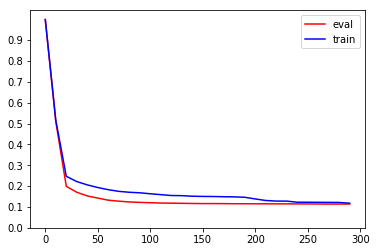

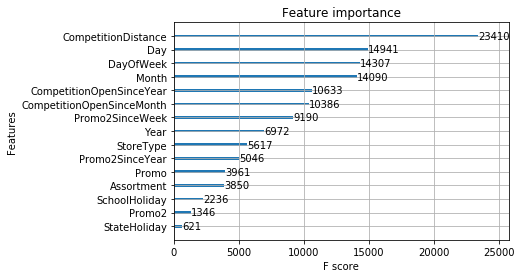

In [74]:
#从最终的训练importnace中看果然是时间序列影响比较大
evaldata = ret['eval']['rmspe'][0:num_trees:10]
traindata = ret['train']['rmspe'][0:num_trees:10]
plt.plot(range(0,num_trees,10),evaldata,color='red',label="eval")
plt.plot(range(0,num_trees,10),traindata,color='blue',label="train")
plt.legend(loc='best')
y_tick = np.arange(0,1,0.1)
plt.yticks(y_tick)
plt.show()
xgb.plot_importance(gbm2)

In [75]:
#预测测试数据
regetTest = pd.read_csv("./test.csv")
replaceID = regetTest[regetTest.Open == 0.0]['Id']
print(replaceID.values)
test_probs = gbm2.predict(dtest)
result = pd.DataFrame({"Id": TESTID , 'Sales': np.exp(test_probs)})
result.loc[result['Id'].isin(replaceID.values),'Sales'] = 0

[  544   677   841 ... 40230 40231 40232]


In [76]:
#预测测试数据输出
result.to_csv("xgboost_submission.csv", index=False)